# Analysis of Facebook Behaviour.
After downloading my personal facebook data from the past ~10 years, ive decided to run my own analysis on it.
To understand my behavioural pattern better ive focused mostly on:
* Reactions and activity during days/months
* Comments, comment frequency and tendency

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime as dt

# Importing configparser for managing files and settings
import configparser as cp

# Importing warnings and turning off deprecation warnings to clear the field of view a bit.
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [3]:
# Establishing a config file and extracting the relevant information within

config = cp.ConfigParser()
config.read("config.ini")
DATA = config.get("links", "DATA")

In [4]:
# Accessing the relevant folders withhin the unzipped file

catalogue = os.listdir(DATA)
activity = os.listdir(DATA+"\\your_facebook_activity")
comments = os.listdir(DATA+"\\your_facebook_activity\\comments_and_reactions")
messages = os.listdir(DATA+"\\your_facebook_activity\\messages")

In [5]:
# Entering the respective Subfolder

for root,_,_ in os.walk(DATA):
    if "comments" in root:
        os.chdir(root)

# Preprocessing of the Dataframe for further analysis

In [7]:
times = []
reacts = []
action = []
actor = []

In [8]:
# Filtering for the relevant columns in the comments folder,
# excluding comment-content and most active days

for i in comments[1:-1]:
    data_path = os.getcwd()+"\\"+i
    file = open(data_path)
    file_open = json.load(file)

    for i in range(len(file_open)):
        times.append(dt.utcfromtimestamp(file_open[i]["timestamp"]))
        reacts.append(file_open[i]["data"][0]["reaction"]["reaction"])
        actor.append(file_open[i]["data"][0]["reaction"]["actor"])
        action.append(file_open[i]["title"])

In [9]:
# Creating the DataFrame for further processing.

comments_df = pd.DataFrame({"times":times, "reactions":reacts, "actor":actor, "actions":action})

In [10]:
def segmenting_time(dataframe, origin):
    
    """ Function takes in a dataframe and a column of origin
        and segments the column of origin into years, months
        days, hours, minutes and seconds.

        This does not remove the original column.
        
        Recommended format: seconds or miliseconds"""

    dataframe["year"] = dataframe[origin].dt.year
    dataframe["month"] = dataframe[origin].dt.month
    dataframe["day"] = dataframe[origin].dt.day
    dataframe["hour"] = dataframe[origin].dt.hour
    dataframe["minute"] = dataframe[origin].dt.minute
    dataframe["second"] = dataframe[origin].dt.second

In [11]:
segmenting_time(comments_df, "times")

In [12]:
privacy = comments_df.columns == "actions"
comments_df.loc[:,~privacy].head()

,times,reactions,actor,year,month,day,hour,minute,second
0,2012-10-10 20:28:08,LIKE,Sergej Nikitin,2012,10,10,20,28,8
1,2012-10-10 20:28:15,LIKE,Sergej Nikitin,2012,10,10,20,28,15
2,2012-10-19 19:39:06,LIKE,Sergej Nikitin,2012,10,19,19,39,6
3,2012-10-26 11:11:23,LIKE,Sergej Nikitin,2012,10,26,11,11,23
4,2012-10-30 20:24:45,LIKE,Sergej Nikitin,2012,10,30,20,24,45


# Exploration

In [14]:
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder(sparse=False)

In [15]:
def create_heatmap(dataframe, x, y):

    """ Function takes in a dataframe and two columns.
        it then shows a heatmap with the first variable as
        the index and the second as summed values, grouped by
        the first one."""
    
    dataframe.set_index(x, inplace=True)

    OHE_x_y = OHE.fit_transform(dataframe)
    OHE_x_y_df = pd.DataFrame(OHE_x_y, columns=OHE.categories_)
    
    OHE_x_y_df.set_index(dataframe.index, inplace=True)
    OHE_x_y_df = OHE_x_y_df.groupby(x).sum()
    
    sns.heatmap(OHE_x_y_df, cmap="mako")

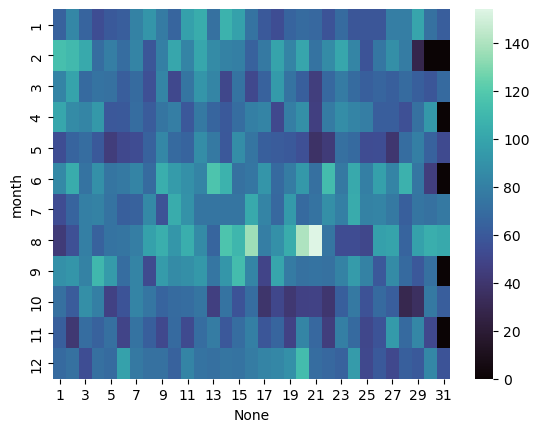

In [16]:
# Creating Sub-DataFrame for months and days and applying OneHotEncoder.
# Exploring the activity over each day of each month,
# to look for potential patterns.


months_days_comments = comments_df[["month", "day"]]
create_heatmap(months_days_comments, "month", "day")

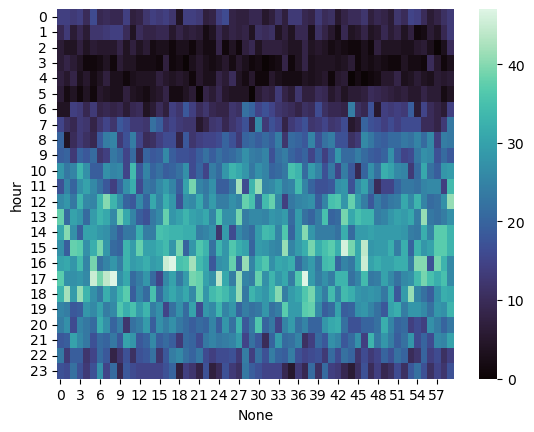

In [17]:
# Repeating the above procedure for hours and minutes of a day,
# showing obvious activity during day times and limited activity during the night.

hours_minutes_comments = comments_df[["hour", "minute"]]
create_heatmap(hours_minutes_comments, "hour", "minutes")

In [18]:
for root,_,_ in os.walk(DATA+"\\your_facebook_activity"):
    if root.endswith("\messages"):
        os.chdir(root)

In [19]:
participants = []
sending_times = []
sender_name = []
content = []

In [21]:
# Filtering for the relevant columns in the messages folder,
# excluding old group conversations (not community chats however)

for i in messages:
    if i == "inbox":
        inbox_data_path = os.getcwd()+"\\"+i
        for i2 in os.listdir(inbox_data_path):
            
            # Since old group conversations are saved in folders that are purely numerical
            # and individual messages and community chats begin with letters, we filter here.
            
            if str.isalpha(i2[0]):
                sub_data_path = inbox_data_path+"\\"+i2

                # Since some conversations hold pictures and other additional files, we filter for messages.
                
                messages = [x for x in os.listdir(sub_data_path) if "message" in x]
                sub_data_path += f"\\{messages[0]}"

                file = open(sub_data_path)
                file_open = json.load(file)

                for m in file_open["messages"]:
                    participants.append([x["name"] for x in file_open["participants"]])
                    sending_times.append(dt.utcfromtimestamp(m["timestamp_ms"]/1000.0))
                    sender_name.append(m["sender_name"])
                    try:
                        content.append(m["content"])
                    except:
                        content.append("None")


In [22]:
messages_df = pd.DataFrame({"sending_times":sending_times, "participants":participants, "sender_name":sender_name, "content":content})

In [23]:
segmenting_time(messages_df, "sending_times")

In [24]:
privacy_messages = ((messages_df.columns == "content") | 
                    (messages_df.columns == "participants") | 
                    (messages_df.columns == "sender_name"))

messages_df.loc[:,~privacy_messages].head()

,sending_times,year,month,day,hour,minute,second
0,2013-07-22 14:33:16.745,2013,7,22,14,33,16
1,2019-04-02 12:56:15.998,2019,4,2,12,56,15
2,2024-06-15 19:59:07.909,2024,6,15,19,59,7
3,2024-05-22 16:59:48.444,2024,5,22,16,59,48
4,2024-05-18 13:03:42.509,2024,5,18,13,3,42


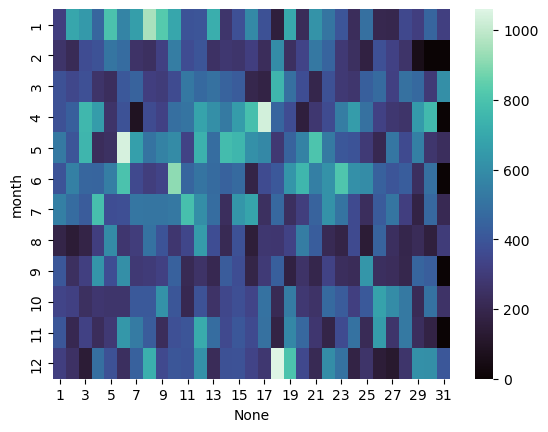

In [31]:
month_day_messages = messages_df[["month", "day"]]
create_heatmap(month_day_messages, "month", "day")

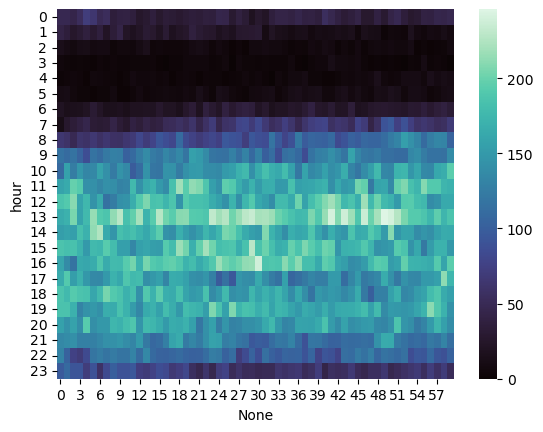

In [33]:
hour_minute_messages = messages_df[["hour", "minute"]]
create_heatmap(hour_minute_messages, "hour", "minute")

Unfortunately neither the Reactions nor the Comments or Messages showed anything out of the norm.
Aside from the obvious time of activity, no special characteristics can be inferred.


# Sentiment Analysis
Since the results from the reactions, comments and messages analysis proved inconclusive or as expected,
we will further be doing a sentiment analysis.

In [ ]:
# Importing the Natural Language Toolkit library as well as all necessary parts
# for further analysis.

import nltk
nltk.download("all")

In [36]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [37]:
def text_processing(text):

    """Basic Function to tokenize, lemmatize text and remove stopwords."""

    base_tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in base_tokens if token not in stopwords.words("english") and 
                       (token not in stopwords.words("german"))]
    
    lemm = WordNetLemmatizer()
    lemm_tokens = [lemm.lemmatize(token) for token in filtered_tokens]

    processed_text = " ".join(lemm_tokens)

    return processed_text

In [38]:
messages_df["processed"] = messages_df["content"].apply(text_processing)

In [39]:
analyzer = SentimentIntensityAnalyzer()

In [40]:
def get_sentiment(text):
    
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores["pos"] > 0 else 0

    return sentiment

In [41]:
messages_df["sentiment"] = messages_df["processed"].apply(get_sentiment)

Now that each message has been given a sentiment, let us take a look at the sentiments over the years and days.

In [43]:
messages_df.groupby("year")["sentiment"].mean()

year
2011    0.056000
2012    0.205298
2013    0.236422
2014    0.215820
2015    0.243545
2016    0.226453
2017    0.213896
2018    0.140373
2019    0.125665
2020    0.128111
2021    0.168068
2022    0.180634
2023    0.193512
2024    0.172767
Name: sentiment, dtype: float64

<Axes: ylabel='sentiment'>

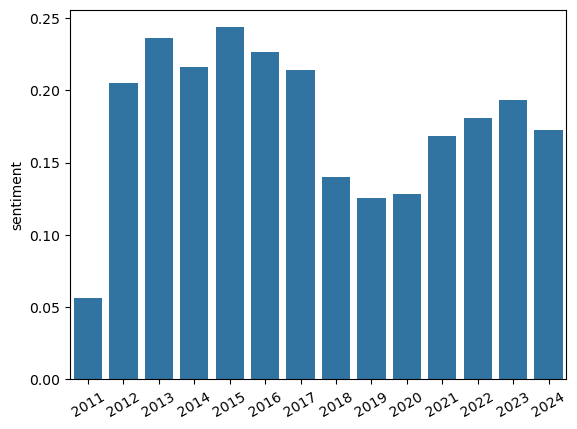

In [58]:
plt.xticks(rotation=30)
sns.barplot(x=sorted(messages_df["year"].unique()), y=messages_df.groupby("year")["sentiment"].mean())

,sending_times,year,month,day,hour,minute,second,sentiment
count,150365,150365.000000,150365.000000,150365.000000,150365.000000,150365.000000,150365.000000,150365.000000
mean,2018-09-30 20:24:25.990821888,2018.265308,6.318186,15.334865,14.501633,29.519855,29.531420,0.169461
min,2011-12-11 19:57:20.128000,2011.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2016-08-27 08:16:57.206000128,2016.000000,4.000000,8.000000,11.000000,15.000000,15.000000,0.000000
50%,2019-04-03 08:34:06.219000064,2019.000000,6.000000,15.000000,15.000000,29.000000,29.000000,0.000000
75%,2020-08-13 19:36:40.456000,2020.000000,9.000000,22.000000,18.000000,45.000000,44.000000,0.000000
max,2024-07-11 22:22:37.166000,2024.000000,12.000000,31.000000,23.000000,59.000000,59.000000,1.000000
std,NaN,2.633445,3.413391,8.581069,4.916725,17.294453,17.329138,0.375160
